# Hamiltonian Neural Network - Double Pendulum System

In [30]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from Systems.DoublePendulum import *
from Systems.Generate_Data import *
from HamiltonianNeuralNetwork.HNN import *
from HamiltonianNeuralNetwork.Train import *
from NumericalIntegration.Numerical_Integration import *

torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [31]:
def initial_condition():
    def sampler():
        min_norm=0.3
        max_norm=0.7
        dim=4
        while True:
            vec = np.random.randn(dim)  # Generate random vector from normal distribution
            norm = np.linalg.norm(vec)  # Compute L2 norm
            if norm == 0:
                continue  # Avoid division by zero
            else:
                break

        vec = vec / norm  # Normalize to unit vector
        scale = np.random.uniform(min_norm, max_norm)
        vec = vec * scale
        x0, y0, px0, py0 = vec[0], vec[1], vec[2], vec[3]

        return np.array([x0,y0,px0,py0]).flatten()
    return sampler()
    

In [32]:
T_max_train = 2*np.pi
nsamples_train = 100*T_max_train/2
ntraj_train = 1750
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750
epochs = 50

#Activations nn.Tanh(), nn.ReLU(), Sin(), nn.Softplus(), PAU(), PadeTypeActivation

act_1 = nn.Tanh()
act_2 = nn.ReLU()

lr = 1e-3
batch_size = 64
sys = DoublePendulum()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [33]:
def DoublePendulum_loss_func(dudt,dudt_est):
    func = torch.nn.MSELoss()
    MSE_dudt = func(dudt_est,dudt)
    return MSE_dudt

loss_func = loss_wrapper(DoublePendulum_loss_func)

In [34]:
def get_Hamiltonians(model,u_exact,u_pred,t_sample,C):
    H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])

    t = t_sample.squeeze(0)
    u_samples = u_pred.squeeze(0)
    #Computed estimated Hamiltonian from values for prediction
    H_nn= torch.tensor([(model.Hamiltonian(u)- C )for u in u_samples])
    #Computed true Hamiltonian values for prediction
    H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
    #Computed NN Hamiltonian for exact
    H_nn_exact = torch.tensor([(model.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - C) for u in u_exact.squeeze(0)])


    return H_exact, H_nn, H_exact_pred, H_nn_exact

In [35]:
def contour_plot_Hamiltonian(model,sys,u_pred):
    u0 = u_pred[0]
    C = model.Hamiltonian(torch.tensor(u0, dtype = torch.float32))- sys.Hamiltonian(u0)

    x = u_pred[:, 0]
    y = u_pred[:, 1]
    px = np.zeros_like(x)  
    py = np.zeros_like(y) 

    X, Y = np.meshgrid(x, y)

    x_flattened = X.flatten()
    y_flattened = Y.flatten()
    px = np.full_like(x_flattened, 0)
    py = np.full_like(y_flattened, 0)
   
    u_samples = np.stack([x_flattened, y_flattened, px, py], axis=1)

    H_true = np.array([sys.Hamiltonian(u) for u in u_samples])
    with torch.no_grad():
       H_learned = torch.tensor([(model.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - C) for u in u_samples])

    #Reshape to grid
    H_true_grid = H_true.reshape(X.shape)
    H_learned_grid = H_learned.reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    cs1 = axes[0].contour(X, Y, H_true_grid, levels=20, cmap='viridis')
    axes[0].set_title('True Hamiltonian $H(x, y, 0, 0)$')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_aspect('equal', 'box')
    fig.colorbar(cs1, ax=axes[0])

    cs2 = axes[1].contour(X, Y, H_learned_grid, levels=20, cmap='viridis')
    axes[1].set_title('Learned Hamiltonian $\hat{H}_\\theta(x, y, 0, 0)$')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_aspect('equal', 'box')
    fig.colorbar(cs2, ax=axes[1])

    plt.tight_layout()
    plt.show()


## Explicit Midpoint

100%|██████████| 10/10 [00:02<00:00,  3.47it/s, epoch=9, loss=0.00338]


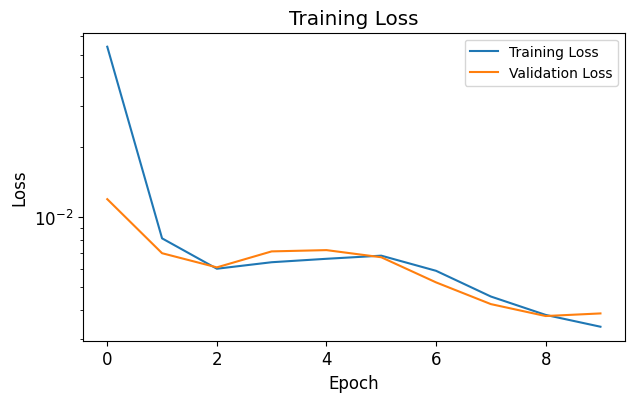

In [7]:
integrator = "midpoint"

(u_start, u_end,_, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end,_, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, dt), dudt

model_exp = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)

trainer = Training(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp, system = sys, batch_size=batch_size,epochs = epochs)
model_exp, trainingdetails_explicit = trainer.train(loss_func)

In [23]:
model_exp,_,_ = load_model(path= "Models/DoublePendulum/DoublePendulum_midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")

### Predicting from Explicit Midpoint

In [24]:
tmax = 15*np.pi
nsamples = 100*15/2
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end, _, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/HamiltonianNeuralNetwork/HNN.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)


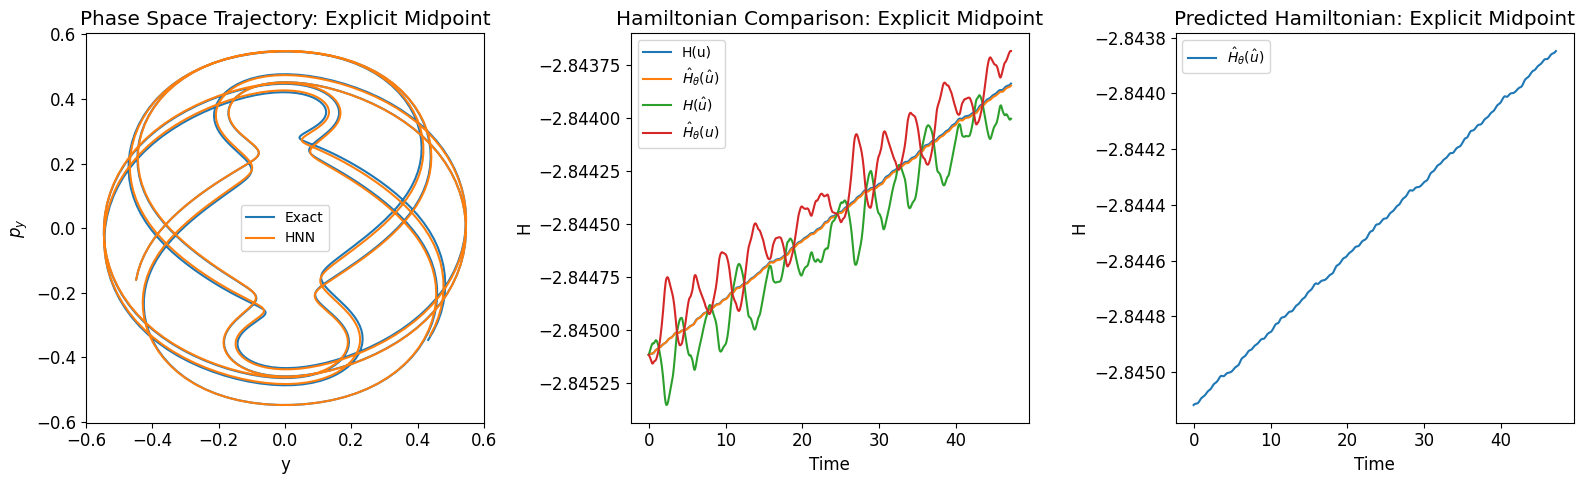

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_exp[0][:, 1], u_phnn_exp[0][:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Explicit Midpoint" )
ax[0].legend()


C =model_exp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))
H_exact, H_exp_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_exp,u_exact,u_phnn_exp,t_sample,C)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Explicit Midpoint")
ax[1].legend()

ax[2].plot(t, H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Predicted Hamiltonian: Explicit Midpoint")
ax[2].legend()
plt.tight_layout() 
plt.show()




## Sympelctic Midpoint

100%|██████████| 10/10 [00:02<00:00,  4.72it/s, epoch=9, loss=0.00281]


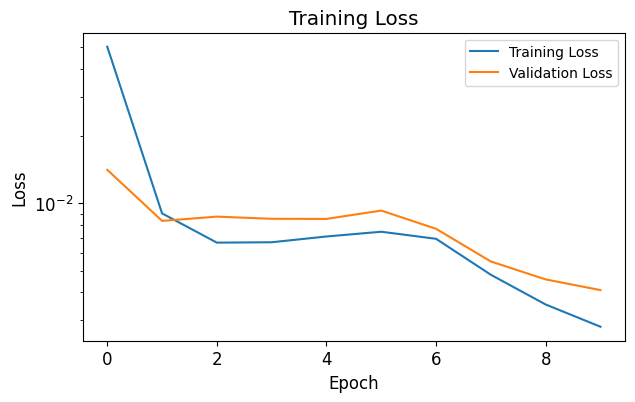

In [12]:
integrator = "symplectic midpoint"

(u_start, u_end, _, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end, _, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, dt), dudt

model_symp = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp= torch.optim.Adam(model_symp.parameters(), lr=lr)

trainer = Training(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp, system = sys, batch_size=batch_size,epochs = epochs)
model_symp, trainingdetails_symp = trainer.train(loss_func)

In [36]:
model_symp,_,_ = load_model(path= "Models/DoublePendulum/DoublePendulum_symplectic midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")

### Predicting from Symplectic Midpoint

In [37]:
tmax = 15*np.pi
nsamples = 100*15/2
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "symplectic midpoint"
ntrajectories = 1

(u_start, u_end, _, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator,u0s=u0s)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


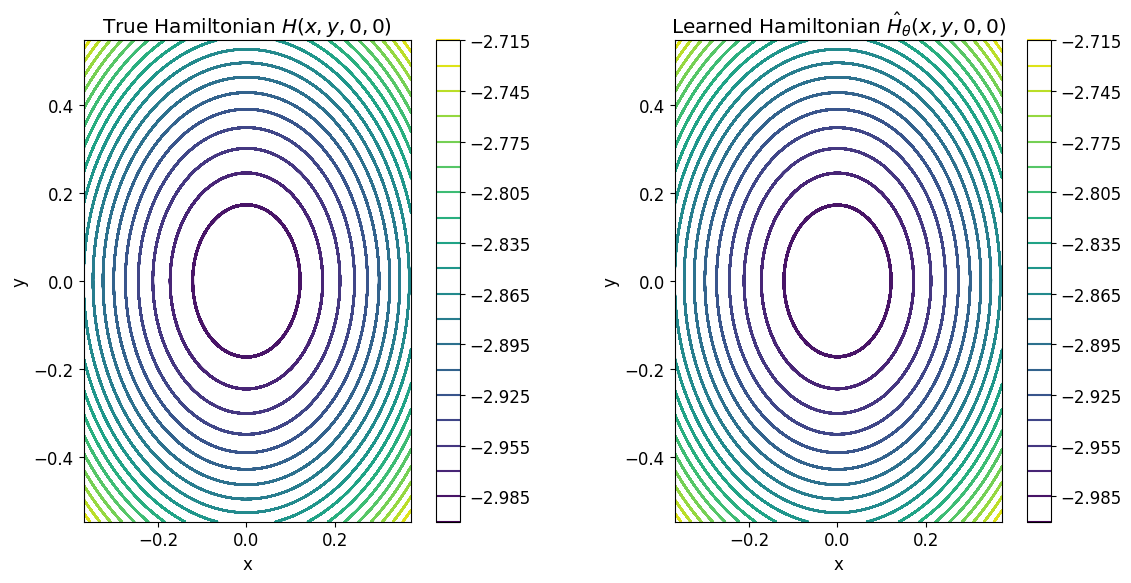

In [38]:
u_pred = u_phnn_symp[0].detach().numpy()
contour_plot_Hamiltonian(model_symp, sys, u_pred)

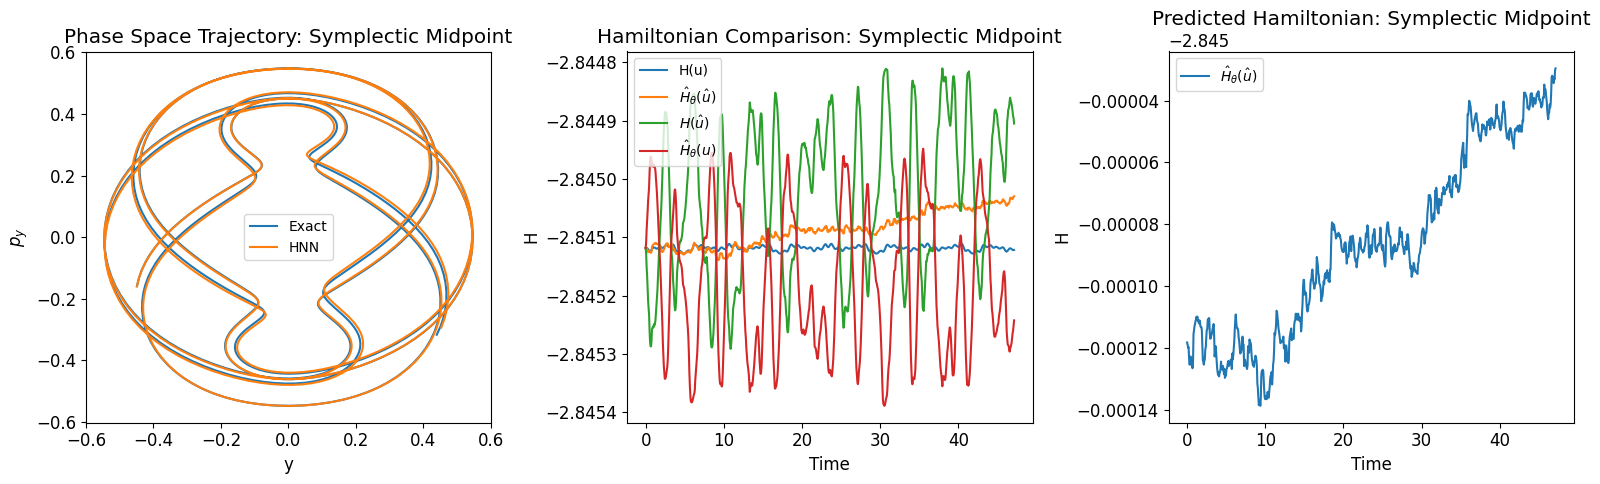

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Symplectic Midpoint" )
ax[0].legend()

C =model_symp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))
H_exact, H_symp_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_symp,u_exact,u_phnn_symp,t_sample,C)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Symplectic Midpoint")
ax[1].legend()

ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Predicted Hamiltonian: Symplectic Midpoint")
ax[2].legend()


plt.tight_layout() 
plt.show()




## Animating Prediction

KeyboardInterrupt: 

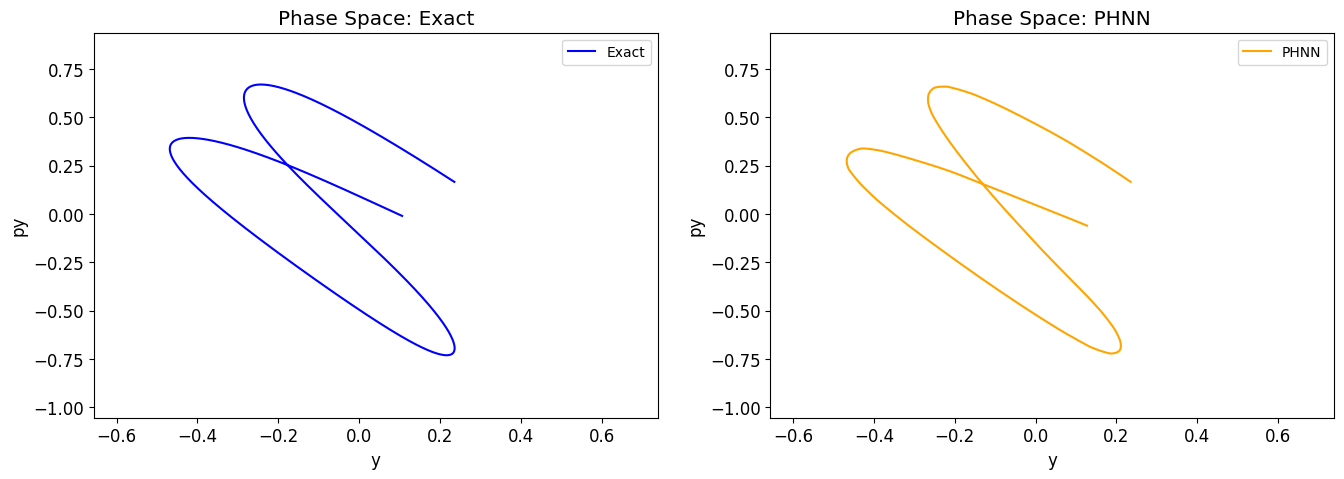

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))


for a in ax:
    a.set_xlabel("y")
    a.set_ylabel("py")
    a.set_xlim([-2, 2])
    a.set_ylim([-1, 1])

ax[0].set_title("Phase Space: Exact")
ax[1].set_title("Phase Space: PHNN")

y_exact = u_exact[0][:, 0]
py_exact = u_exact[0][:, 1]
y_phnn = u_phnn_symp[0][:, 0]
py_phnn = u_phnn_symp[0][:, 1]

#If tensors, convert to numpy
if hasattr(y_exact, 'detach'):
    y_exact = y_exact.detach().cpu().numpy()
    py_exact = py_exact.detach().cpu().numpy()
    y_phnn = y_phnn.detach().cpu().numpy()
    py_phnn = py_phnn.detach().cpu().numpy()


frame_skip = 10
frame_indices = np.arange(0, len(y_exact), frame_skip)


line_exact, = ax[0].plot([], [], label="Exact", color='blue')
line_phnn, = ax[1].plot([], [], label="PHNN", color='orange')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim([min(y_exact)*1.4, max(y_exact)*1.4])
ax[0].set_ylim([min(py_exact)*1.4, max(py_exact)*1.4])
ax[1].set_xlim([min(y_exact)*1.4, max(y_exact)*1.4])
ax[1].set_ylim([min(py_exact)*1.4, max(py_exact)*1.4])


def update(i):
    frame = frame_indices[i]
    line_exact.set_data(y_exact[:frame], py_exact[:frame])
    line_phnn.set_data(y_phnn[:frame], py_phnn[:frame])
    return line_exact, line_phnn

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(frame_indices),
    interval=30,  
    blit=True
)

HTML(ani.to_jshtml())


## Testing Error Analysis - Comparing Activation Functions

### Loading Saved Models

In [40]:
model_exp_PAU_ReLU, _, loss_exp_PAU_ReLU = load_model("Models/DoublePendulum/DoublePendulum_midpoint_50epoch_PAU()_ReLU()_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_exp_PAU_Soft, _, loss_exp_PAU_Soft = load_model("Models/DoublePendulum/DoublePendulum_midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_exp_Sin_ReLU, _, loss_exp_Sin_ReLU = load_model("Models/DoublePendulum/DoublePendulum_midpoint_50epoch_Sin()_ReLU()_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_exp_Sin_Soft, _, loss_exp_Sin_Soft = load_model("Models/DoublePendulum/DoublePendulum_midpoint_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_exp_Tanh_ReLU, _, loss_exp_Tanh_ReLU = load_model("Models/DoublePendulum/DoublePendulum_midpoint_50epoch_Tanh()_ReLU()_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_exp_Tanh_soft, _, loss_exp_Tanh_soft = load_model("Models/DoublePendulum/DoublePendulum_midpoint_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")

model_symp_PAU_ReLU, _, loss_symp_PAU_ReLU = load_model("Models/DoublePendulum/DoublePendulum_symplectic midpoint_50epoch_PAU()_ReLU()_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_symp_PAU_Soft, _, loss_symp_PAU_Soft = load_model("Models/DoublePendulum/DoublePendulum_symplectic midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_symp_Sin_ReLU, _, loss_symp_Sin_ReLU = load_model("Models/DoublePendulum/DoublePendulum_symplectic midpoint_50epoch_Sin()_ReLU()_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_symp_Sin_Soft, _, loss_symp_Sin_Soft = load_model("Models/DoublePendulum/DoublePendulum_symplectic midpoint_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_symp_Tanh_ReLU, _, loss_symp_Tanh_ReLU = load_model("Models/DoublePendulum/DoublePendulum_symplectic midpoint_50epoch_Tanh()_ReLU()_batchsize_64_shape_torch.Size([549500, 4]).pt")
model_symp_Tanh_soft, _, loss_symp_Tanh_soft = load_model("Models/DoublePendulum/DoublePendulum_symplectic midpoint_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")


### Plotting Training Loss Error - Each Activation Function

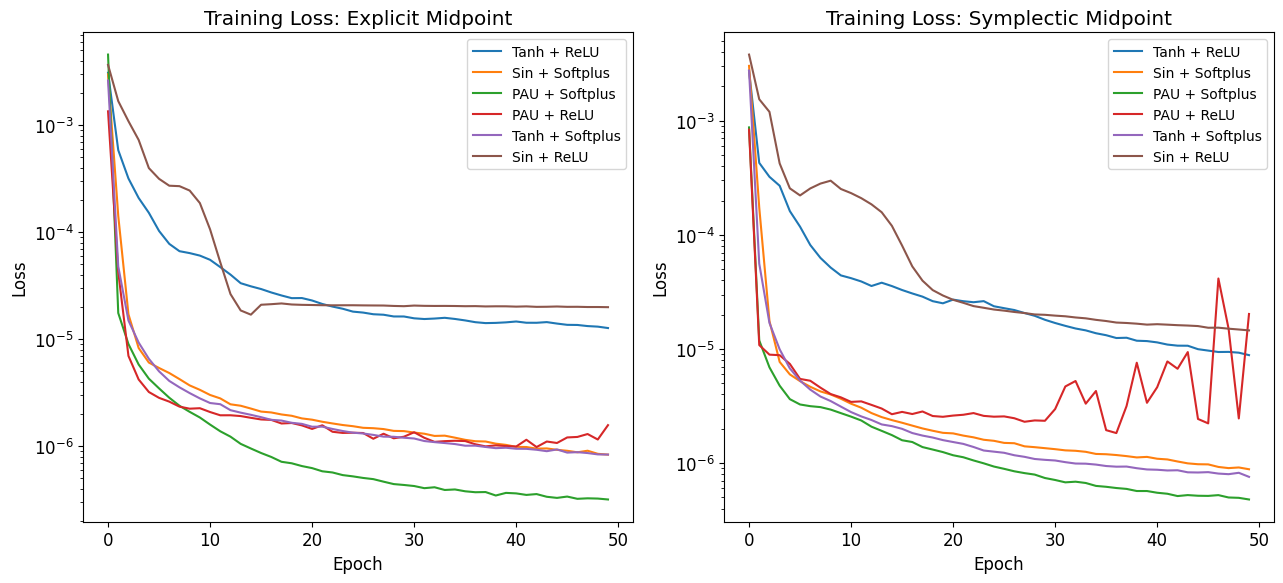

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

ax[0].plot(loss_exp_Tanh_ReLU, label = "Tanh + ReLU")
ax[0].plot(loss_exp_Sin_Soft, label = "Sin + Softplus")
ax[0].plot(loss_exp_PAU_Soft, label = "PAU + Softplus")
ax[0].plot(loss_exp_PAU_ReLU, label = "PAU + ReLU")
ax[0].plot(loss_exp_Tanh_soft, label = "Tanh + Softplus")
ax[0].plot(loss_exp_Sin_ReLU, label = "Sin + ReLU")
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss: Explicit Midpoint')



ax[1].plot(loss_symp_Tanh_ReLU, label = "Tanh + ReLU")
ax[1].plot(loss_symp_Sin_Soft, label = "Sin + Softplus")
ax[1].plot(loss_symp_PAU_Soft, label = "PAU + Softplus")
ax[1].plot(loss_symp_PAU_ReLU, label = "PAU + ReLU")
ax[1].plot(loss_symp_Tanh_soft, label = "Tanh + Softplus")
ax[1].plot(loss_symp_Sin_ReLU, label = "Sin + ReLU")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Loss: Symplectic Midpoint')

plt.tight_layout() 
plt.show()


### Test Loss Comparison

In [74]:
T_max_test = 20
nsamples_test = 100*2
ntraj_test = 100

dt_test = T_max_test/nsamples_test
nt_test = round(T_max_test / dt_test)
t_test = np.linspace(0, T_max_test, nt_test + 1)

sys = DoublePendulum()

traject = np.linspace(1,ntraj_test,ntraj_test)


In [75]:
(u_start, u_end, _, dt), dudt, u_test_exp, u0_test = generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "midpoint")
(u_start, u_end, _, dt), dudt, u_test_symp, u0_test= generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "symplectic midpoint",u0s = u0_test)

100%|██████████| 100/100 [00:05<00:00, 19.27it/s]


In [76]:
u_exp_PAU_Soft, _ = model_exp_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Sin_Soft, _ = model_exp_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Tanh_ReLU, _ = model_exp_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_PAU_ReLU, _ = model_exp_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Tanh_soft, _ = model_exp_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Sin_ReLU, _ = model_exp_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)


u_symp_PAU_Soft, _ = model_symp_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Sin_Soft, _ = model_symp_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Tanh_ReLU, _ = model_symp_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_PAU_ReLU, _ = model_symp_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Tanh_soft, _ = model_symp_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Sin_ReLU, _ = model_symp_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)

/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/HamiltonianNeuralNetwork/HNN.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/NumericalIntegration/Numerical_Integration.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


In [77]:
def test_loss(pred,exact):
    mse_per_time = torch.mean((pred - exact) ** 2, dim=(0, 2)) 
    return mse_per_time

mse_per_time = test_loss(u_exp_PAU_Soft,u_test_exp)

/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_33816/331684558.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse_per_time = torch.mean((pred - exact) ** 2, dim=(0, 2))


#### Test Loss Comparison - Coordinates

In [78]:
err_exp_PAU_Soft = test_loss(u_exp_PAU_Soft,u_test_exp)
err_exp_Sin_Soft = test_loss(u_exp_Sin_Soft,u_test_exp)
err_exp_Tanh_ReLU = test_loss(u_exp_Tanh_ReLU,u_test_exp)
err_exp_PAU_ReLU = test_loss(u_exp_PAU_ReLU,u_test_exp)
err_exp_Tanh_soft = test_loss(u_exp_Tanh_soft,u_test_exp)
err_exp_Sin_ReLU = test_loss(u_exp_Sin_ReLU,u_test_exp)


err_symp_PAU_Soft =test_loss(u_symp_PAU_Soft,u_test_symp)
err_symp_Sin_Soft = test_loss(u_symp_Sin_Soft,u_test_symp)
err_symp_Tanh_ReLU = test_loss(u_symp_Tanh_ReLU,u_test_symp)
err_symp_PAU_ReLU = test_loss(u_symp_PAU_ReLU,u_test_symp)
err_symp_Tanh_soft = test_loss(u_symp_Tanh_soft,u_test_symp)
err_symp_Sin_ReLU = test_loss(u_symp_Sin_ReLU,u_test_symp)


/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_33816/331684558.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse_per_time = torch.mean((pred - exact) ** 2, dim=(0, 2))


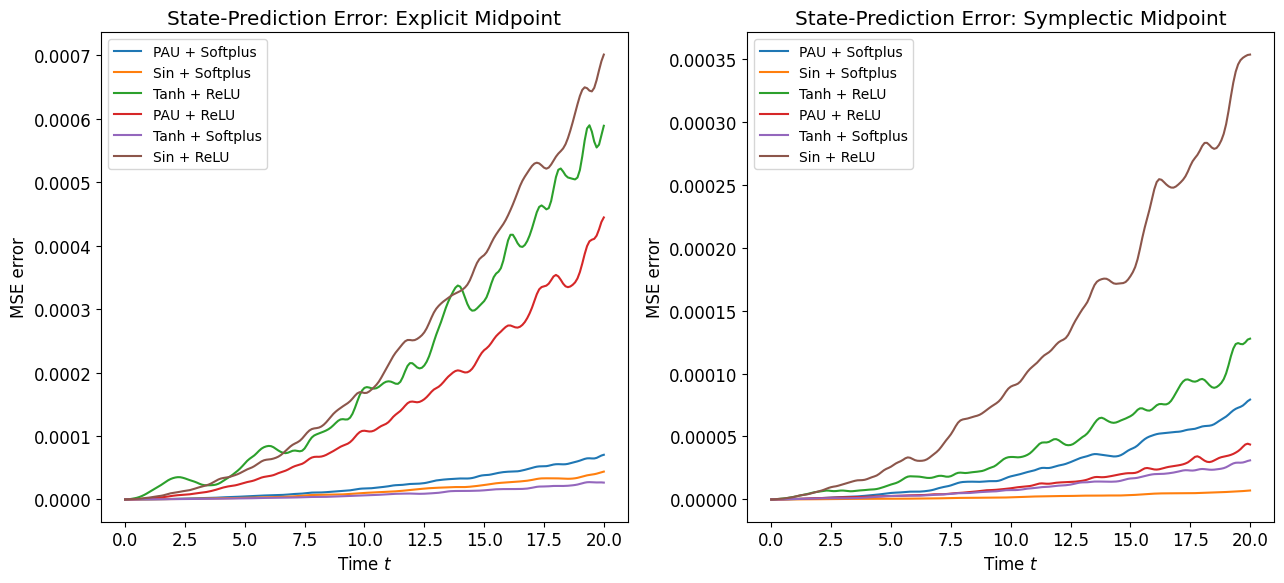

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))


ax[0].plot(t_test, err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(t_test, err_exp_Tanh_ReLU, label="Tanh + ReLU")
ax[0].plot(t_test, err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].plot(t_test, err_exp_Tanh_soft, label="Tanh + Softplus")
ax[0].plot(t_test, err_exp_Sin_ReLU, label="Sin + ReLU")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("State-Prediction Error: Explicit Midpoint")
ax[0].legend()




ax[1].plot(t_test, err_symp_PAU_Soft, label="PAU + Softplus")
ax[1].plot(t_test, err_symp_Sin_Soft, label="Sin + Softplus")
ax[1].plot(t_test, err_symp_Tanh_ReLU, label="Tanh + ReLU")
ax[1].plot(t_test, err_symp_PAU_ReLU, label="PAU + ReLU")
ax[1].plot(t_test, err_symp_Tanh_soft, label="Tanh + Softplus")
ax[1].plot(t_test, err_symp_Sin_ReLU, label="Sin + ReLU")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("State-Prediction Error: Symplectic Midpoint")
ax[1].legend()

plt.tight_layout() 
plt.show()

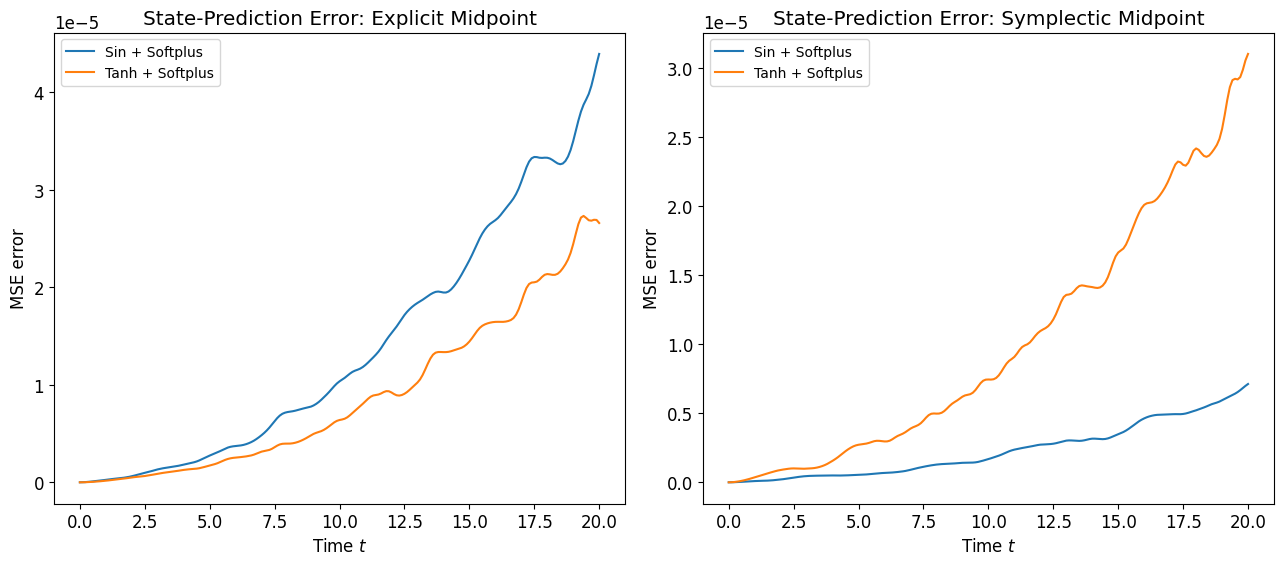

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))



#ax[0].plot(traject, err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(t_test, err_exp_Tanh_soft, label="Tanh + Softplus")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("State-Prediction Error: Explicit Midpoint")
ax[0].legend()



ax[1].plot(t_test, err_symp_Sin_Soft, label="Sin + Softplus")
ax[1].plot(t_test, err_symp_Tanh_soft, label="Tanh + Softplus")
#ax[1].plot(traject, err_symp_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("State-Prediction Error: Symplectic Midpoint")
ax[1].legend()

plt.tight_layout() 
plt.show()

#### Test Loss Comparison - Hamiltonian

In [81]:
def get_Hamiltonians(model, u_exact, u_pred, sys=DoublePendulum()):
    """
    u_exact: numpy array of shape [N, T, 4]
    u_pred:  torch tensor of shape [N, T, 4]
    Returns:
        All Hamiltonians as tensors of shape [N, T, 1]
    """
    # Convert numpy array to torch tensor
    u_exact = torch.tensor(u_exact, dtype=torch.float32)

    N, T, d = u_exact.shape
    u_exact_flat = u_exact.reshape(-1, d)
    u_pred_flat = u_pred.reshape(-1, d)

    zero_state = torch.tensor([[0., 0., 0., 0.]], dtype=torch.float32)
    

    # Compute Hamiltonians
    H_exact = torch.tensor(
        [sys.Hamiltonian(u) for u in u_exact_flat], dtype=torch.float32
    ).reshape(N, T, 1)

    H_nn = torch.tensor(
        [model.Hamiltonian(u) - model.Hamiltonian(zero_state) for u in u_pred_flat],
        dtype=torch.float32
    ).reshape(N, T, 1)

    H_exact_pred = torch.tensor(
        [sys.Hamiltonian(u) for u in u_pred_flat], dtype=torch.float32
    ).reshape(N, T, 1)

    H_nn_exact = torch.tensor(
        [model.Hamiltonian(u) - model.Hamiltonian(zero_state) for u in u_exact_flat],
        dtype=torch.float32
    ).reshape(N, T, 1)

    return H_exact, H_nn, H_exact_pred, H_nn_exact


In [82]:
def get_Hamiltonians(model, u_exact, u_pred, sys=DoublePendulum()):
    """
    u_exact: numpy array of shape [N, T, 4]
    u_pred:  torch tensor of shape [N, T, 4]
    
    Returns:
        All Hamiltonians as tensors of shape [N, T, 1]
    """
    import torch

    # Convert numpy array to torch tensor
    u_exact = torch.tensor(u_exact, dtype=torch.float32)

    N, T, d = u_exact.shape
    u_exact_flat = u_exact.reshape(-1, d)
    u_pred_flat = u_pred.reshape(-1, d)

    # Compute per-trajectory offset C
    C = torch.tensor([
        model.Hamiltonian(u_exact[i, 0]) - sys.Hamiltonian(u_exact[i, 0])
        for i in range(N)
    ], dtype=torch.float32).reshape(N, 1, 1)

    # Compute Hamiltonians
    H_exact = torch.tensor(
        [sys.Hamiltonian(u) for u in u_exact_flat], dtype=torch.float32
    ).reshape(N, T, 1)

    H_nn = torch.tensor(
        [model.Hamiltonian(u) for u in u_pred_flat], dtype=torch.float32
    ).reshape(N, T, 1) - C  # Subtract per-trajectory offset

    H_exact_pred = torch.tensor(
        [sys.Hamiltonian(u) for u in u_pred_flat], dtype=torch.float32
    ).reshape(N, T, 1)

    H_nn_exact = torch.tensor(
        [model.Hamiltonian(u) for u in u_exact_flat], dtype=torch.float32
    ).reshape(N, T, 1) - C  # Subtract per-trajectory offset

    return H_exact, H_nn, H_exact_pred, H_nn_exact


In [83]:
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_PAU_Soft,model= model_exp_PAU_Soft)
H_err_exp_PAU_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Sin_Soft,model= model_exp_Sin_Soft)
H_err_exp_Sin_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Tanh_ReLU,model= model_exp_Tanh_ReLU)
H_err_exp_Tanh_ReLU = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_PAU_ReLU,model= model_exp_PAU_ReLU)
H_err_exp_PAU_ReLU =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Tanh_soft,model= model_exp_Tanh_soft)
H_err_exp_Tanh_soft =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Sin_ReLU,model= model_exp_Sin_ReLU)
H_err_exp_Sin_ReLU =  test_loss(H_model_exact,H_exact)



H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_PAU_Soft,model= model_symp_PAU_Soft)
H_err_symp_PAU_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Sin_Soft,model= model_symp_Sin_Soft)
H_err_symp_Sin_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Tanh_ReLU,model= model_symp_Tanh_ReLU)
H_err_symp_Tanh_ReLU = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_PAU_ReLU,model= model_symp_PAU_ReLU)
H_err_symp_PAU_ReLU =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Tanh_soft,model= model_symp_Tanh_soft)
H_err_symp_Tanh_soft =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Sin_ReLU,model= model_symp_Sin_ReLU)
H_err_symp_Sin_ReLU =  test_loss(H_model_exact,H_exact)


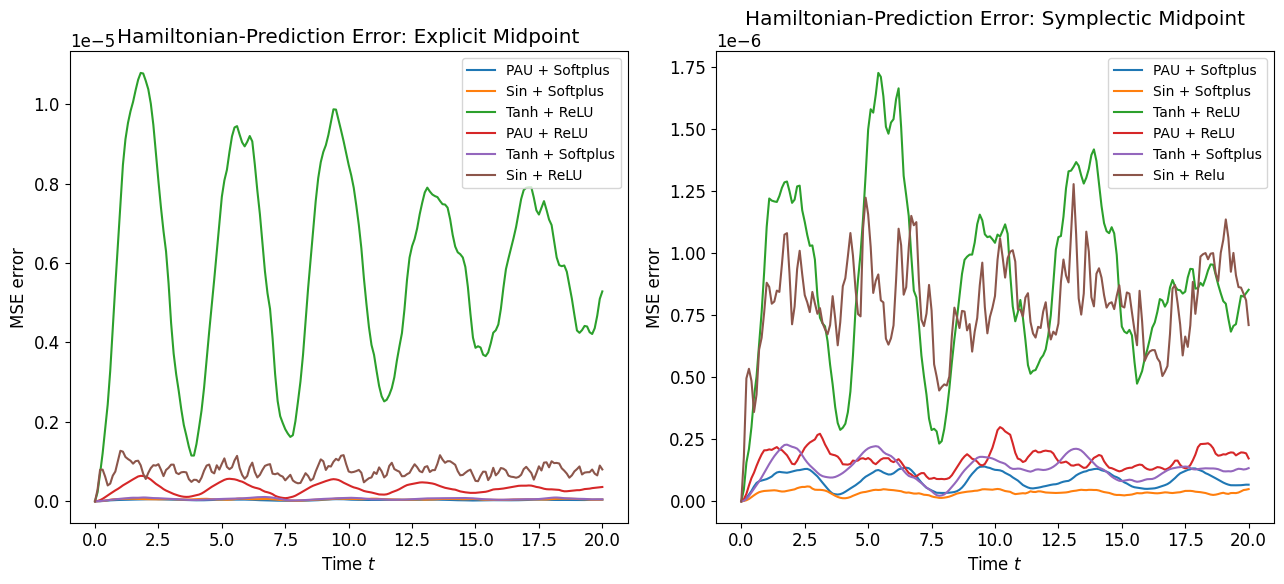

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))


ax[0].plot(t_test, H_err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, H_err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(t_test, H_err_exp_Tanh_ReLU, label="Tanh + ReLU")
ax[0].plot(t_test, H_err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].plot(t_test, H_err_exp_Tanh_soft, label="Tanh + Softplus")
ax[0].plot(t_test, H_err_exp_Sin_ReLU, label="Sin + ReLU")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("Hamiltonian-Prediction Error: Explicit Midpoint")
ax[0].legend()





ax[1].plot(t_test, H_err_symp_PAU_Soft, label="PAU + Softplus")
ax[1].plot(t_test, H_err_symp_Sin_Soft, label="Sin + Softplus")
ax[1].plot(t_test, H_err_symp_Tanh_ReLU, label="Tanh + ReLU")
ax[1].plot(t_test, H_err_symp_PAU_ReLU, label="PAU + ReLU")
ax[1].plot(t_test, H_err_symp_Tanh_soft, label="Tanh + Softplus")
ax[1].plot(t_test, H_err_symp_Sin_ReLU, label="Sin + Relu")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("Hamiltonian-Prediction Error: Symplectic Midpoint")
ax[1].legend()
 


plt.tight_layout() 
plt.show()

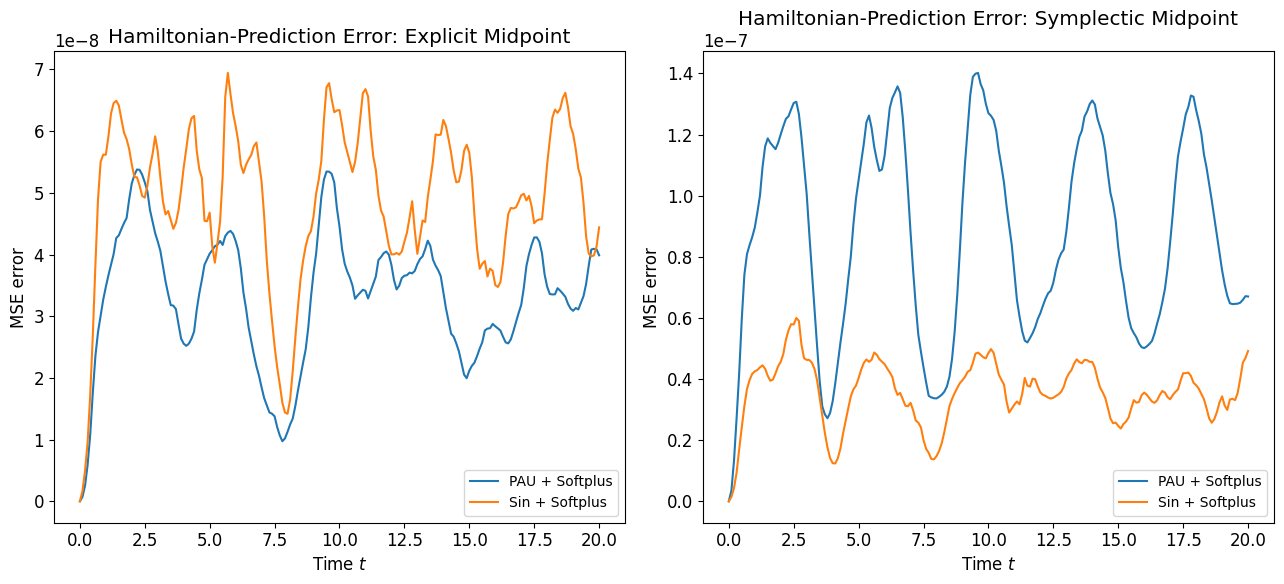

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))



ax[0].plot(t_test, H_err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, H_err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("Hamiltonian-Prediction Error: Explicit Midpoint")
ax[0].legend()



ax[1].plot(t_test, H_err_symp_PAU_Soft, label="PAU + Softplus")
ax[1].plot(t_test, H_err_symp_Sin_Soft, label="Sin + Softplus")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("Hamiltonian-Prediction Error: Symplectic Midpoint")
ax[1].legend()

plt.tight_layout() 
plt.show()